In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

import umap
import MulticoreTSNE
import fitsne
import LargeVis
from sklearn.manifold import SpectralEmbedding, Isomap
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

### Pull the data from the internet

In [2]:
if not os.path.exists('GSE93374_Merged_all_020816_DGE.txt'):
    !wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE93nnn/GSE93374/suppl/GSE93374_Merged_all_020816_DGE.txt.gz
    !wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE93nnn/GSE93374/suppl/GSE93374_cell_metadata.txt.gz
    !gunzip GSE93374_Merged_all_020816_DGE.txt.gz
    !gunzip GSE93374_cell_metadata.txt.gz

In [3]:
dataframe = pd.read_csv('GSE93374_Merged_all_020816_DGE.txt', sep='\t')
metadataframe = pd.read_csv('GSE93374_cell_metadata.txt', sep='\t')
metadataframe = metadataframe.set_index('1.ID')
metadataframe = metadataframe.loc[dataframe.T.index]

data = dataframe.values.T.astype(np.float64, order='C')

data.shape

(21086, 26774)

In [4]:
labels = pd.Categorical(metadataframe['7.clust_all'])
mapping = {v:k for k,v in dict(enumerate(set(labels))).items()}
labels = np.array(labels.map(lambda x: mapping[x]))
labels[np.isnan(labels)]= -1
labels.shape, len(set(labels))

((21086,), 21)

### Now let's use UMAP to embed these points into a two dimensional space.

In [5]:
fit = umap.UMAP(n_neighbors=15, random_state=42, metric='cosine')
%time u = fit.fit_transform(data)

CPU times: user 8min 58s, sys: 16.1 s, total: 9min 14s
Wall time: 9min 15s


In [6]:
output = pd.DataFrame(u, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_mouserna_umap1.csv')

In [7]:
pd.DataFrame(u, columns=('x','y')).to_csv('embedding_mouserna_umap.csv')

Text(0.5,1,'Mouse scRNA data embedded into two dimensions by UMAP')

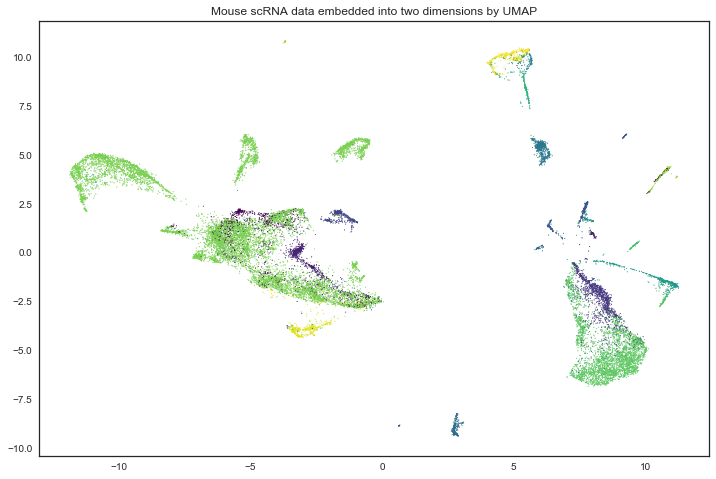

In [8]:
plt.scatter(u[:,0], u[:,1], c=labels, cmap="viridis", s=0.5)
plt.title('Mouse scRNA data embedded into two dimensions by UMAP')

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
%time pca_data = pca.fit_transform(data)

CPU times: user 9min, sys: 1min 47s, total: 10min 47s
Wall time: 6min 50s


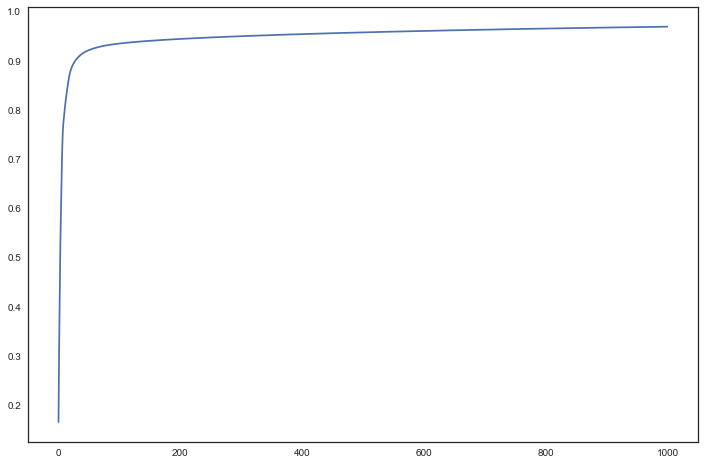

In [10]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

## UMAP

In [11]:
umapper = umap.UMAP(random_state=42)
%time u_umap_pca = umapper.fit_transform(pca_data)

CPU times: user 27.5 s, sys: 2.12 s, total: 29.7 s
Wall time: 27.7 s


In [12]:
output = pd.DataFrame(u_umap_pca, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_mouserna_umap_pca1.csv')

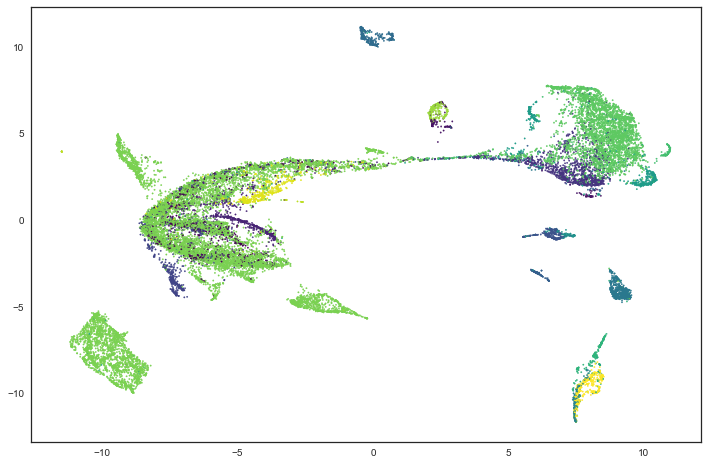

In [13]:
plt.scatter(u_umap_pca[:,0], u_umap_pca[:,1], c=labels, cmap="viridis", s=2)

### T-SNE

In [14]:
fit_tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=1, random_state=42)
%time u_tsne = fit_tsne.fit_transform(pca_data)

CPU times: user 4min 15s, sys: 2.25 s, total: 4min 17s
Wall time: 4min 18s


In [15]:
output = pd.DataFrame(u_tsne, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_mouserna_tsne1.csv')

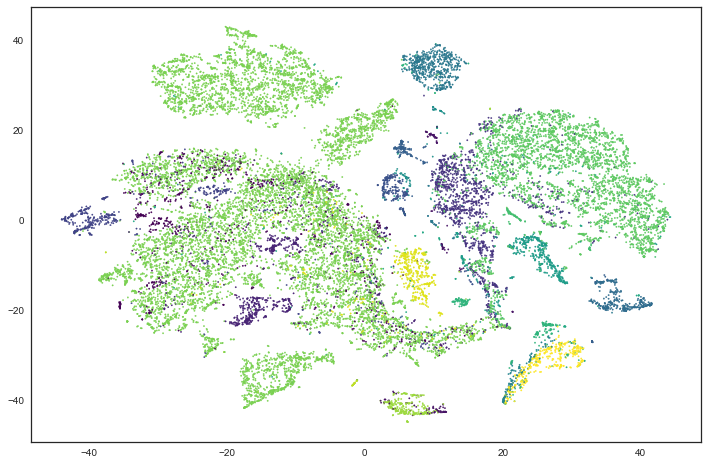

In [16]:
plt.scatter(u_tsne[:,0], u_tsne[:,1], c=labels, cmap="viridis", s=2)

### PCA

The old standby of PCA which is blindingly fast to compute and often used as an initialization to many of the more complex algorithms.  This isn't really a competitor but instead should be thought of as a strawman.  Given that other algorithms initialize with these values one would hope that they can do better.

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
%time u_pca = pca.fit_transform(data)

CPU times: user 36.7 s, sys: 43.5 s, total: 1min 20s
Wall time: 1min 26s


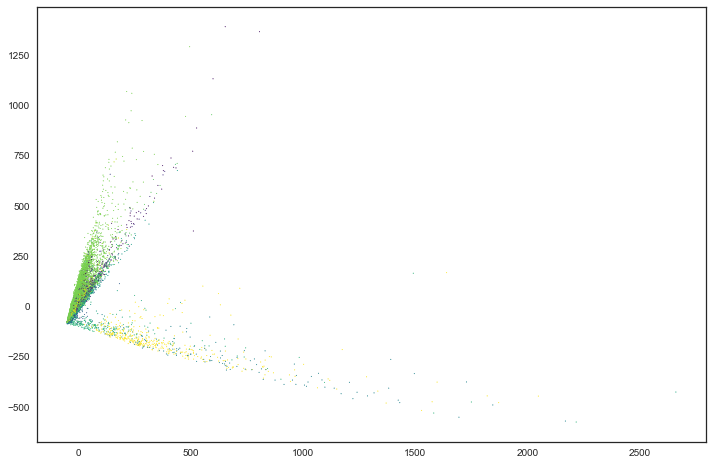

In [18]:
plt.scatter(u_pca[:,0], u_pca[:,1], c=labels, cmap="viridis", s=0.5)

## FIt-SNE

In [19]:
%time u_fitsne = fitsne.FItSNE(pca_data.astype(np.double, order='C'), nthreads=1, rand_seed=42)

CPU times: user 2min 4s, sys: 6.02 s, total: 2min 11s
Wall time: 2min 11s


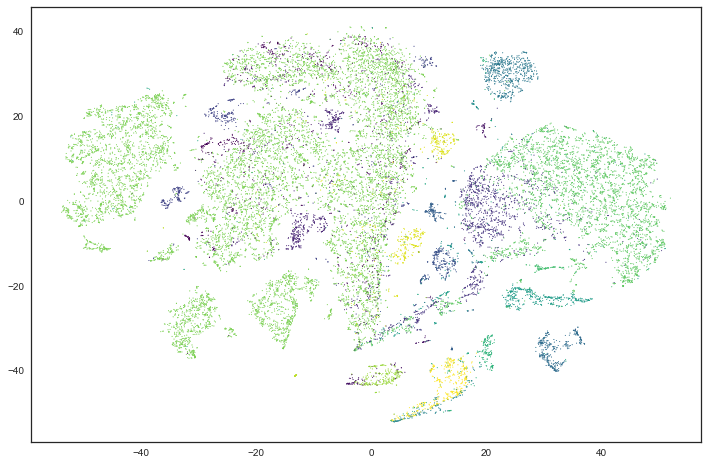

In [20]:
plt.scatter(u_fitsne[:,0], u_fitsne[:,1], c=labels, cmap="viridis", s=0.5)

In [21]:
np.save('fitsne_mouserna_embedding1.npy', u_fitsne)

In [22]:
output = pd.DataFrame(u_fitsne, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_mouserna_fitsne1.csv')

## LargeVis

In [23]:
largevis_data = pca_data.astype(np.float32, order='C')
LargeVis.loadarray(largevis_data)
largevis_n_samples = int(largevis_data.shape[0] / 100.0)

In [24]:
%time u_largevis = LargeVis.run(2, 1, largevis_n_samples)

CPU times: user 6min 15s, sys: 3.62 s, total: 6min 19s
Wall time: 6min 17s


In [25]:
u_largevis = np.array(u_largevis)

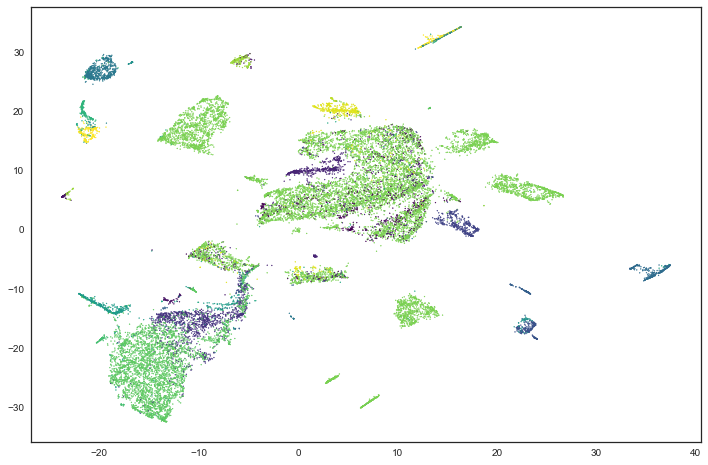

In [26]:
plt.scatter(u_largevis[:,0], u_largevis[:,1], c=labels, cmap="viridis", s=1)

In [27]:
np.save('largevis_mouserna_embedding1.npy', u_largevis)

In [28]:
output = pd.DataFrame(u_largevis, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_mouserna_largevis1.csv')

## Laplacian Eigenmaps

In [29]:
%time u_laplacian = SpectralEmbedding(n_neighbors=15).fit_transform(pca_data)

CPU times: user 9min 24s, sys: 4.75 s, total: 9min 29s
Wall time: 7min 50s


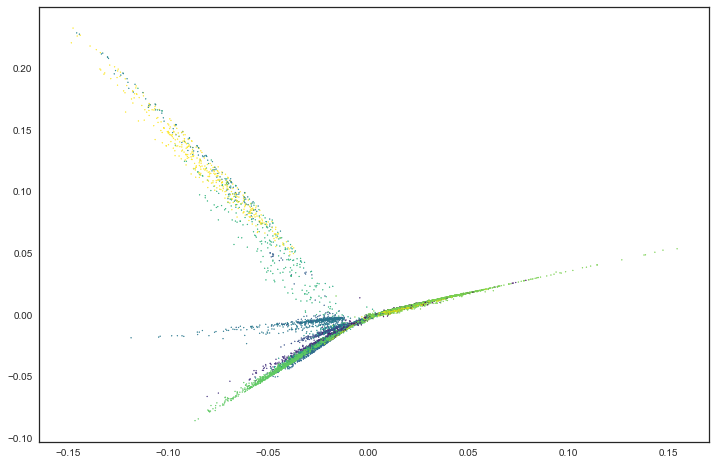

In [30]:
plt.scatter(u_laplacian[:,0], u_laplacian[:,1], c=labels, cmap="viridis", s=1)

In [31]:
np.save('eigenmaps_mouserna_embedding1.npy', u_laplacian)

In [32]:
output = pd.DataFrame(u_laplacian, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_mouserna_eigenmaps1.csv')

## Isomap

In [34]:
%time u_isomap = Isomap(n_neighbors=15).fit_transform(pca_data)

CPU times: user 12min 25s, sys: 56.2 s, total: 13min 21s
Wall time: 15min 23s


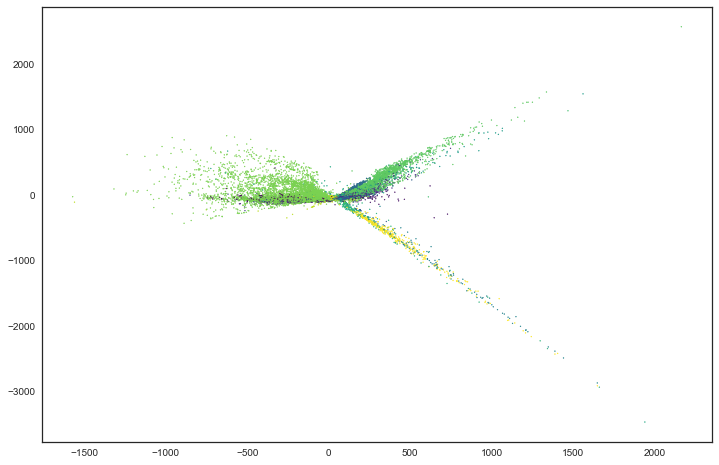

In [35]:
plt.scatter(u_isomap[:,0], u_isomap[:,1], c=labels, cmap="viridis", s=1)

In [36]:
np.save('isomap_mouserna_embedding1.npy', u_isomap)

In [37]:
output = pd.DataFrame(u_isomap, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_mouserna_isomap1.csv')